### Homework 2: More Exploratory Data Analysis
## Gene Expression Data and Election Polls 

Due: Thursday, September 29, 2016 11:59 PM


#### Submission Instructions
To submit your homework, create a folder named **lastname_firstinitial_hw#** and place your IPython notebooks, data files, and any other files in this folder. Your IPython Notebooks should be completely executed with the results visible in the notebook. We should not have to run any code. Make sure to share the private repo with my github account (mdog) and submit the repo path through blackboard.

---

## Introduction

John Tukey wrote in [Exploratory Data Analysis, 1977](http://www.amazon.com/Exploratory-Data-Analysis-Wilder-Tukey/dp/0201076160/ref=pd_bbs_sr_2/103-4466654-5303007?ie=UTF8&s=books&qid=1189739816&sr=8-2): "The greatest value of a picture is when it forces us to notice what we never expected to see." In this assignment we will continue using our exploratory data analysis tools, but apply it to new sets of data: [gene expression](http://en.wikipedia.org/wiki/Gene_expression) and polls from the [2012 Presidental Election](http://en.wikipedia.org/wiki/United_States_presidential_election,_2012) and from the [2014 Senate Midterm Elections](http://en.wikipedia.org/wiki/United_States_Senate_elections,_2014).   

**First**: You will use exploratory data analysis and apply the [singular value decomposition](http://en.wikipedia.org/wiki/Singular_value_decomposition) (SVD) to a gene expression data matrix to determine if the the date that the gene expression samples are processed has large effect on the variability seen in the data.  

**Second**: You will use the polls from the 2012 Presidential Elections to determine (1) Is there a pollster bias in presidential election polls? and (2) Is the average of polls better than just one poll?

**Finally**: You will use the [HuffPost Pollster API](http://elections.huffingtonpost.com/pollster/api) to extract the polls for the current 2014 Senate Midterm Elections and provide a preliminary prediction of the result of each state.

#### Data

We will use the following data sets: 

1. A gene expression data set called `exprs_GSE5859.csv` and sample annotation table called `sampleinfo_GSE5859.csv` which are both available on Github in the 2014_data repository: [expression data set](https://github.com/cs109/2014_data/blob/master/exprs_GSE5859.csv) and [sample annotation table](https://github.com/cs109/2014_data/blob/master/sampleinfo_GSE5859.csv).  

2. Polls from the [2012 Presidential Election: Barack Obama vs Mitt Romney](http://elections.huffingtonpost.com/pollster/2012-general-election-romney-vs-obama). The polls we will use are from the [Huffington Post Pollster](http://elections.huffingtonpost.com/pollster).  

3. Polls from the [2014 Senate Midterm Elections](http://elections.huffingtonpost.com/pollster) from the [HuffPost Pollster API](http://elections.huffingtonpost.com/pollster/api). 

---

In [1]:
%%bash
mkdir -p data

## Load Python modules

In [2]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import requests 
from io import StringIO
import numpy as np
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting 
import datetime as dt # module for manipulating dates and times
import numpy.linalg as lin # module for performing linear algebra operations

## Problem 1

In this problem we will be using a [gene expression](http://en.wikipedia.org/wiki/Gene_expression) data set obtained from a [microarray](http://en.wikipedia.org/wiki/DNA_microarray) experiement [Read more about the specific experiment here](http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE5859).  There are two data sets we will use:  

1. The gene expression intensities where the rows represent the features on the microarray (e.g. genes) and the columsns represent the different microarray samples.  

2. A table that contains the information about each of the samples (columns in the gene expression data set) such as the sex, the age, the treatment status, the date the samples were processed.  Each row represents one sample. 

#### Problem 1(a) 
Read in the two files from Github: [exprs_GSE5859.csv](https://github.com/cs109/2014_data/blob/master/exprs_GSE5859.csv) and [sampleinfo_GSE5859.csv](https://github.com/cs109/2014_data/blob/master/sampleinfo_GSE5859.csv) as pandas DataFrames called `exprs` and `sampleinfo`. Use the gene names as the index of the `exprs` DataFrame.

In [3]:
%%bash
if [ ! -f data/exprs_GSE5859.csv ]; then
    curl https://raw.githubusercontent.com/cs109/2014_data/master/exprs_GSE5859.csv -o data/exprs_GSE5859.csv
fi
if [ ! -f data/sampleinfo_GSE5859.csv ]; then
    curl https://raw.githubusercontent.com/cs109/2014_data/master/sampleinfo_GSE5859.csv -o data/sampleinfo_GSE5859.csv
fi

In [4]:
#your code here
exprs = pd.read_csv("data/exprs_GSE5859.csv", index_col=0)
sampleinfo = pd.read_csv("data/sampleinfo_GSE5859.csv")

Make sure the order of the columns in the gene expression DataFrame match the order of file names in the sample annotation DataFrame. If the order of the columns the `exprs` DataFrame do not match the order of the file names in the `sampleinfo` DataFrame, reorder the columns in the `exprs` DataFrame. 

**Note**: The column names of the gene expression DataFrame are the filenames of the orignal files from which these data were obtained.  

**Hint**: The method `list.index(x)` [[read here](https://docs.python.org/3/tutorial/datastructures.html)] can be used to return the index in the list of the first item whose value is x. It is an error if there is no such item. To check if the order of the columns in `exprs` matches the order of the rows in `sampleinfo`, you can check using the method `.all()` on a Boolean or list of Booleans: 

Example code: `(exprs.columns == sampleinfo.filename).all()`

In [5]:
#your code here
(exprs.columns == sampleinfo.filename).all()

False

In [6]:
exprs = exprs[[list(exprs.columns).index(i) for i in sampleinfo.filename]]
(exprs.columns == sampleinfo.filename).all()

True

Show the head of the two tables: `exprs` and `sampleinfo`. 

In [7]:
#your code here
exprs.head()

,GSM25349.CEL.gz,GSM25350.CEL.gz,GSM25356.CEL.gz,GSM25357.CEL.gz,GSM25358.CEL.gz,GSM25359.CEL.gz,GSM25360.CEL.gz,GSM25361.CEL.gz,GSM25377.CEL.gz,GSM25378.CEL.gz,...,GSM136719.CEL.gz,GSM136720.CEL.gz,GSM136721.CEL.gz,GSM136722.CEL.gz,GSM136723.CEL.gz,GSM136724.CEL.gz,GSM136725.CEL.gz,GSM136726.CEL.gz,GSM136727.CEL.gz,GSM136729.CEL.gz
1007_s_at,6.627014,6.249807,5.934128,6.145268,6.091270,6.041186,6.050375,6.063847,6.226106,6.358282,...,6.466445,6.533592,6.631492,6.513362,6.440706,6.704324,6.488579,6.809481,6.133068,6.155473
1053_at,6.939184,6.818038,7.047962,7.422477,7.272361,7.128216,6.750719,6.836287,6.738022,7.367895,...,7.032885,7.156344,7.018025,6.973322,6.884738,7.120898,7.517410,7.200596,7.280781,7.111583
117_at,5.113570,5.074096,5.371201,5.266550,5.342047,5.063876,5.315898,5.483652,6.689444,6.482782,...,5.661112,5.127260,5.151840,5.505602,5.687689,4.942651,5.247190,5.237239,5.401876,5.302628
121_at,7.833862,7.780682,7.458197,7.655948,7.546555,7.072670,7.092984,6.954225,7.489785,7.388539,...,7.769734,7.815864,7.683279,7.883231,7.913621,7.834196,7.331864,7.357102,7.607461,7.456453
1255_g_at,3.152269,3.111747,3.018932,3.154545,3.107954,3.224284,3.114241,3.044975,3.304038,2.887919,...,3.257484,3.339234,3.298384,3.150654,3.344501,3.230285,3.175846,3.105092,3.225123,3.090149


In [8]:
sampleinfo.head()

,ethnicity,date,filename,sex
0,CEU,2003-02-04,GSM25349.CEL.gz,M
1,CEU,2003-02-04,GSM25350.CEL.gz,M
2,CEU,2002-12-17,GSM25356.CEL.gz,M
3,CEU,2003-01-30,GSM25357.CEL.gz,M
4,CEU,2003-01-03,GSM25358.CEL.gz,M


#### Problem 1(b)

Extract the year and month as integers from the `sampleinfo` table. 

**Hint**: To convert a Series or a column of a pandas DataFrame that contains a date-like object, you can use the `to_datetime` function [[read here](http://pandas.pydata.org/pandas-docs/stable/timeseries.html)].  This will create a `DatetimeIndex` which can be used to extract the month and year for each row in the DataFrame. 

In [9]:
#your code here
sampleinfo["date"] = pd.to_datetime(sampleinfo.date)
sampleinfo["month"] = [d.month for d in sampleinfo.date]
sampleinfo["year"] = [d.year for d in sampleinfo.date]

#### Problem 1(c)

Convert the dates in the `date` column from the `sampleinfo` table into days since October 31, 2002. Add a column to the `sampleinfo` DataFrame titled `elapsedInDays` containing the days since October 31, 2002.  Show the head of the `sampleinfo` DataFrame which includes the new column.  

**Hint**: Use the `datetime` module to create a new `datetime` object for the specific date October 31, 2002. Then, subtract the October 31, 2002 date from each date from the `date` column in the `sampleinfo` DataFrame. 

In [10]:
#your code here
bday = dt.datetime(2002,10,31)
sampleinfo["elapsedInDays"] = sampleinfo.date - bday
sampleinfo["elapsedInDays"] = [d.days for d in sampleinfo["elapsedInDays"]]
sampleinfo.head()

,ethnicity,date,filename,sex,month,year,elapsedInDays
0,CEU,2003-02-04,GSM25349.CEL.gz,M,2,2003,96
1,CEU,2003-02-04,GSM25350.CEL.gz,M,2,2003,96
2,CEU,2002-12-17,GSM25356.CEL.gz,M,12,2002,47
3,CEU,2003-01-30,GSM25357.CEL.gz,M,1,2003,91
4,CEU,2003-01-03,GSM25358.CEL.gz,M,1,2003,64


#### Problem 1(d)

Use exploratory analysis and the singular value decomposition (SVD) of the gene expression data matrix to determine if the date the samples were processed has large effect on the variability seen in the data or if it is just ethnicity (which is confounded with date). 

**Hint**: See the end of the [lecture from 9/23/2014 for help with SVD](https://github.com/cs109/2014/blob/master/lectures/2014_09_23-lecture/data_scraping_transcript.ipynb)
First subset the the `sampleinfo` DataFrame to include only the CEU ethnicity.  Call this new subsetted DataFrame `sampleinfoCEU`.  Show the head of `sampleinfoCEU` DataFrame. 

In [11]:
#your code here
sampleinfoCEU = sampleinfo[sampleinfo.ethnicity == "CEU"]
sampleinfoCEU.head()

,ethnicity,date,filename,sex,month,year,elapsedInDays
0,CEU,2003-02-04,GSM25349.CEL.gz,M,2,2003,96
1,CEU,2003-02-04,GSM25350.CEL.gz,M,2,2003,96
2,CEU,2002-12-17,GSM25356.CEL.gz,M,12,2002,47
3,CEU,2003-01-30,GSM25357.CEL.gz,M,1,2003,91
4,CEU,2003-01-03,GSM25358.CEL.gz,M,1,2003,64


Next, subset the `exprs` DataFrame to only include the samples with the CEU ethnicity. Name this new subsetted DataFrame `exprsCEU`. Show the head of the `exprsCEU` DataFrame. 

In [12]:
#your code here
exprsCEU = exprs[sampleinfoCEU.filename]
exprsCEU.head()

,GSM25349.CEL.gz,GSM25350.CEL.gz,GSM25356.CEL.gz,GSM25357.CEL.gz,GSM25358.CEL.gz,GSM25359.CEL.gz,GSM25360.CEL.gz,GSM25361.CEL.gz,GSM25377.CEL.gz,GSM25378.CEL.gz,...,GSM48658.CEL.gz,GSM48660.CEL.gz,GSM48661.CEL.gz,GSM48662.CEL.gz,GSM48663.CEL.gz,GSM48664.CEL.gz,GSM48665.CEL.gz,GSM136725.CEL.gz,GSM136726.CEL.gz,GSM136727.CEL.gz
1007_s_at,6.627014,6.249807,5.934128,6.145268,6.091270,6.041186,6.050375,6.063847,6.226106,6.358282,...,6.501510,6.558100,6.618286,6.869995,5.981000,6.403285,6.248702,6.488579,6.809481,6.133068
1053_at,6.939184,6.818038,7.047962,7.422477,7.272361,7.128216,6.750719,6.836287,6.738022,7.367895,...,7.066686,7.386702,6.407958,7.089180,7.120923,7.018998,7.155419,7.517410,7.200596,7.280781
117_at,5.113570,5.074096,5.371201,5.266550,5.342047,5.063876,5.315898,5.483652,6.689444,6.482782,...,5.600514,5.232676,5.630720,4.944748,5.275577,5.770358,5.616842,5.247190,5.237239,5.401876
121_at,7.833862,7.780682,7.458197,7.655948,7.546555,7.072670,7.092984,6.954225,7.489785,7.388539,...,7.437535,7.714650,7.416252,7.746448,8.001434,7.626723,7.452299,7.331864,7.357102,7.607461
1255_g_at,3.152269,3.111747,3.018932,3.154545,3.107954,3.224284,3.114241,3.044975,3.304038,2.887919,...,3.009983,3.151203,3.199709,3.159496,3.149710,3.242780,3.433125,3.175846,3.105092,3.225123


Check to make sure the order of the columns in the `exprsCEU` DataFrame matches the rows in the `sampleinfoCEU` DataFrame.  

In [13]:
#your code here
(exprsCEU.columns == sampleinfoCEU.filename).all()

True

Compute the average gene expression intensity in the `exprsCEU` DataFrame across all the samples. For each sample in the `exprsCEU` DataFrame, subtract the average gene expression intensity from each of the samples. Show the head of the mean normalized gene expression data.  

In [14]:
#your code here
meanGene = exprsCEU.mean(axis=1)
meanNormailizedGene = exprsCEU.apply(lambda col: col - meanGene)
meanNormailizedGene.head()

,GSM25349.CEL.gz,GSM25350.CEL.gz,GSM25356.CEL.gz,GSM25357.CEL.gz,GSM25358.CEL.gz,GSM25359.CEL.gz,GSM25360.CEL.gz,GSM25361.CEL.gz,GSM25377.CEL.gz,GSM25378.CEL.gz,...,GSM48658.CEL.gz,GSM48660.CEL.gz,GSM48661.CEL.gz,GSM48662.CEL.gz,GSM48663.CEL.gz,GSM48664.CEL.gz,GSM48665.CEL.gz,GSM136725.CEL.gz,GSM136726.CEL.gz,GSM136727.CEL.gz
1007_s_at,0.365059,-0.012149,-0.327827,-0.116687,-0.170685,-0.220769,-0.211580,-0.198109,-0.035849,0.096327,...,0.239554,0.296144,0.356331,0.608040,-0.280956,0.141330,-0.013254,0.226624,0.547526,-0.128887
1053_at,-0.136032,-0.257178,-0.027254,0.347260,0.197144,0.053000,-0.324497,-0.238930,-0.337195,0.292678,...,-0.008531,0.311485,-0.667259,0.013964,0.045706,-0.056219,0.080203,0.442193,0.125379,0.205564
117_at,-0.490556,-0.530031,-0.232926,-0.337577,-0.262080,-0.540250,-0.288228,-0.120475,1.085317,0.878655,...,-0.003613,-0.371451,0.026594,-0.659379,-0.328549,0.166231,0.012716,-0.356936,-0.366887,-0.202251
121_at,0.418026,0.364847,0.042362,0.240113,0.130720,-0.343165,-0.322852,-0.461611,0.073949,-0.027296,...,0.021700,0.298814,0.000417,0.330612,0.585598,0.210887,0.036463,-0.083972,-0.058733,0.191626
1255_g_at,0.018335,-0.022187,-0.115002,0.020611,-0.025980,0.090351,-0.019693,-0.088959,0.170104,-0.246015,...,-0.123951,0.017269,0.065775,0.025562,0.015776,0.108846,0.299192,0.041912,-0.028842,0.091189


Using this mean normalized gene expression data, compute the projection to the first Principal Component (PC1).  

**Hint**: Use the `numpy.linalg.svd()` function in the `numpy.linalg` module (or the `scipy.linalg.svd()` function in the `scipy.linalg` module) to apply an [singular value decomposition](http://en.wikipedia.org/wiki/Singular_value_decomposition) to a matrix.  

In [15]:
#your code here
U, S, V_t = np.linalg.svd(meanNormailizedGene.as_matrix())
PC1 = V_t[0]

Create a histogram using the values from PC1.  Use a bin size of 25.  

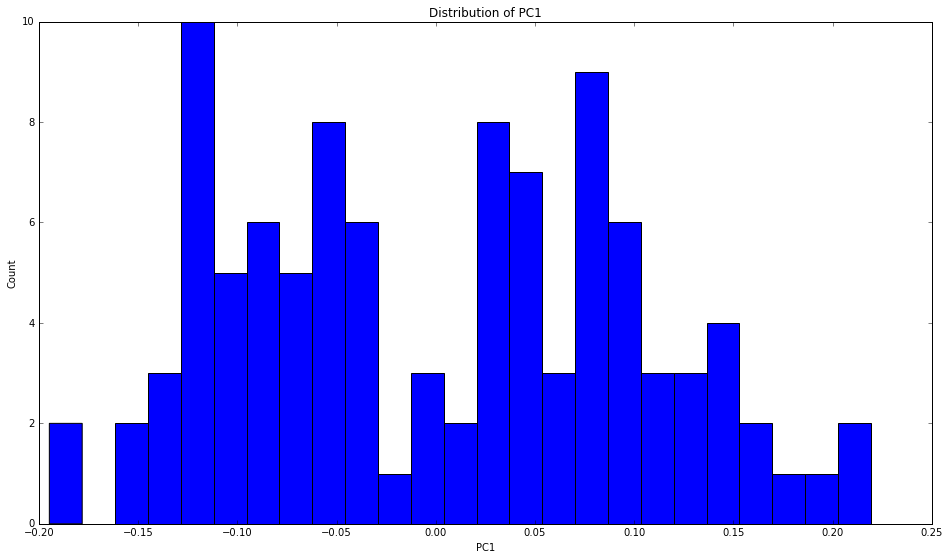

In [16]:
#your code here
plt.figure(figsize=(16,9))
plt.hist(PC1 , bins=25)
plt.title('Distribution of PC1')
plt.xlabel('PC1')
plt.ylabel('Count')
plt.show()

Create a scatter plot with the days since October 31, 2002 on the x-axis and PC1 on the y-axis.

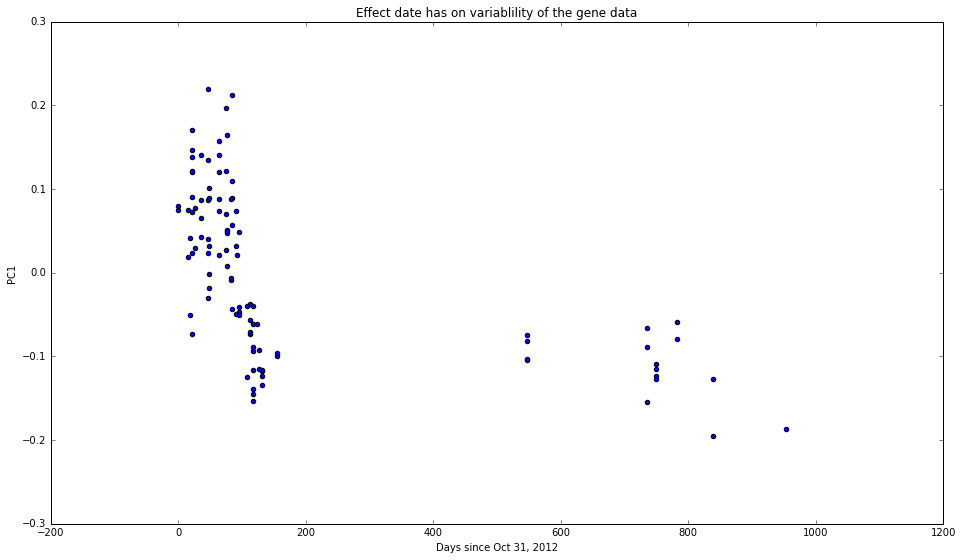

In [17]:
#your code here
plt.figure(figsize=(16,9))
plt.scatter(sampleinfoCEU['elapsedInDays'].values, PC1)
plt.xlabel('Days since Oct 31, 2012')
plt.ylabel('PC1')
plt.title('Effect date has on variablility of the gene data')
plt.show()

Around what day do you notice a difference in the way the samples were processed?

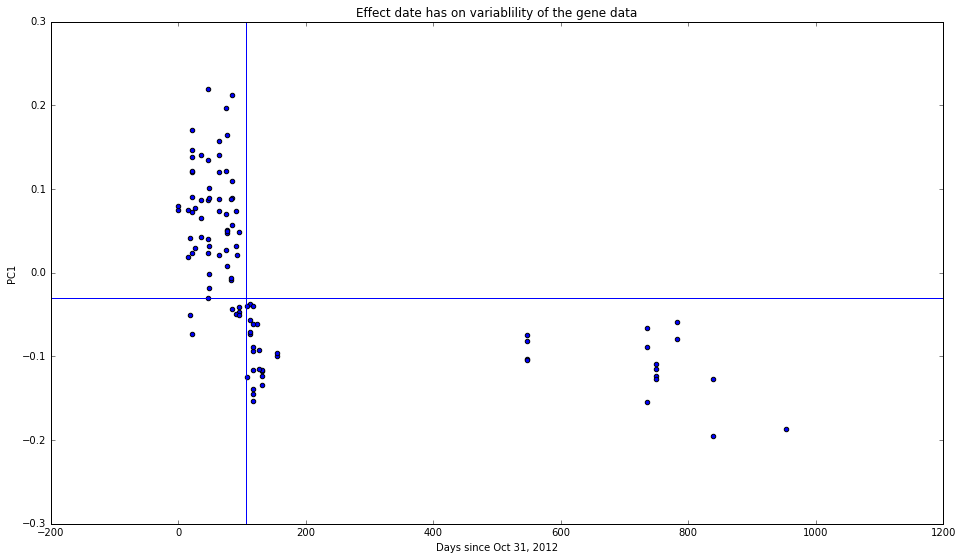

In [18]:
#your code here

plt.figure(figsize=(16,9))
plt.scatter(sampleinfoCEU['elapsedInDays'].values, PC1)
plt.xlabel('Days since Oct 31, 2012')
#plt.xlim(0,200)
plt.ylabel('PC1')
plt.axvline(x=107)
plt.axhline(y=-0.03)
plt.title('Effect date has on variablility of the gene data')
plt.show()

# Answer:
> Before the 107th day, there were almost no samples with PC1 values less than -0.03. After this day, all samples have PC1 values below this. Maybe something changed arount this day.

## Discussion for Problem 1

*Write a brief discussion of your conclusions to the questions and tasks above in 100 words or less.*

---


> The gene expression data is over my head. Nonetheless, using principle component analysis and just looking at the first component, we notice a change in the samples after day 107. Up until then, PC1 values were above -0.03 exept for a few points. After that, they were all below PC1.

# Submission Instructions

To submit your homework, create a folder named **lastname_firstinitial_hw#** and place your IPython notebooks, data files, and any other files in this folder. Your IPython Notebooks should be completely executed with the results visible in the notebook. We should not have to run any code. Make sure to share the private repo with my github account (mdog) and submit the repo path through blackboard.
